# Explorative analysis of first data from Twitter

In [7]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

In [8]:
src = '../data'
data = pd.read_csv(join(src, 'diagnosed_diabetes_clean.csv'), 
                   parse_dates=['created_at'])

In [9]:
data.columns

Index(['attachments.media', 'author.created_at', 'author.description',
       'author.id', 'author.location', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count',
       'author.public_metrics.listed_count',
       'author.public_metrics.tweet_count', 'author.url', 'author.username',
       'author_id', 'context_annotations', 'conversation_id', 'created_at',
       'entities.annotations', 'entities.hashtags', 'entities.mentions',
       'entities.urls', 'id', 'in_reply_to_user.created_at', 'lang',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'public_metrics.retweet_count',
       'referenced_tweets', 'source', 'text', 'recent'],
      dtype='object')

## Data frame content exploration

### Hashtags

In [10]:
def extract_hashtags(tagstring):
    if tagstring == tagstring:
        mod = tagstring[1:-1]
        mod = mod.replace('{', '')
        mod = mod.replace('"', '')
        mod = mod.replace('start: ', '')
        mod = mod.replace('end: ', '')
        mod = mod.replace('tag: ', '')
        mod = mod.split('}, ')
        dicts = [{'start':int(m.split(', ')[0]), 'end':int(m.split(', ')[1]),
                  'tag':m.split(', ')[2].replace('}', '')} for m in mod]
        return dicts
    else:
        return np.nan

In [11]:
data['split_hashtags'] = data['entities.hashtags'].apply(extract_hashtags)

In [13]:
hashtags = pd.DataFrame()
for i, row in data[['author.username', 'split_hashtags']].iterrows():
    lst = row['split_hashtags']
    if lst == lst:
        for dct in lst:
            hashtags = hashtags.append({
                'user':row['author.username'],
                'hashtag':dct['tag']}, ignore_index=True)
            
    if row['author.username'] == 'zenjar':
        break

In [14]:
hashtags.value_counts('hashtag')[0:20]

hashtag
diabetes             6
Diabetes             3
portion              2
limit                2
mealprep             2
nutrition            2
Serving              2
kidney               2
sugar                2
dietitian            2
HoHoHellNo           2
HeartHealth          2
weightlossjourney    2
Choice               2
cookies              2
ketogenic            1
ketogenicdiet        1
ketolife             1
ketorecipes          1
ketodietplan         1
dtype: int64

### Locations

In [15]:
print('{} users have provided a location'\
      .format(len(data.dropna(subset=['author.location']))))

131 users have provided a location


In [16]:
data['author.location'].value_counts()[0:15]

Texas               6
Jacksonville, FL    4
Omaha, NE           3
California          3
USA                 3
Georgia, USA        3
Los Angeles Area    2
Seattle             2
San Antonio, TX     2
UK                  2
London              2
Orlando             1
Palo Alto, CA       1
Apopka, FL          1
Sydney, AU          1
Name: author.location, dtype: int64

### Followers

In [17]:
def bracketize_followers(fls):
    if fls <= 100:
        return '0-100'
    elif fls <= 500:
        return '101-500'
    elif fls <= 1000:
        return '501-1000'
    elif fls <= 2000:
        return '1001-2000'
    elif fls <= 3000:
        return '2001-3000'
    elif fls <= 4000:
        return '4001-5000'
    elif fls <= 7500:
        return '5001-7500'
    elif fls <= 10000:
        return '7501-10000'
    else:
        return '>10000'

In [18]:
follower_categories = ["0-100","101-500","501-1000","1001-2000","2001-3000",
                "3001-4000","4001-5000","5001-7500","7501-10000",">10000"]
data['followers'] = data['author.public_metrics.followers_count']\
    .apply(bracketize_followers)
data['followers'] = pd.Categorical(data['followers'],
                                categories=follower_categories, ordered=True)

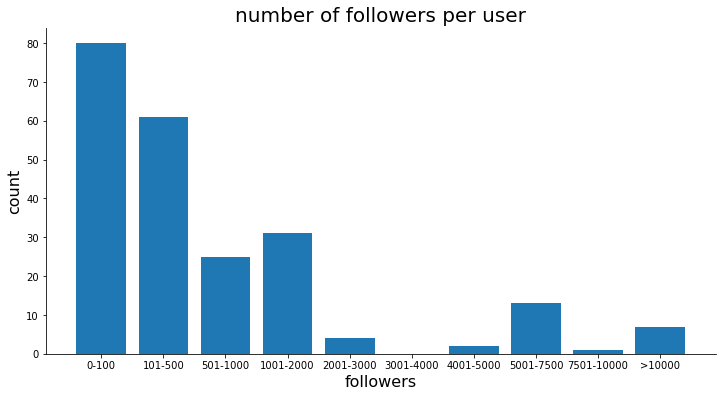

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(data['followers'].value_counts().sort_index().index, 
       data['followers'].value_counts().sort_index().values)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('followers', fontsize=16)
ax.set_title('number of followers per user', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../plots/number_of_followers_per_user.pdf')

## Tweet frequency

In [20]:
data['created_at_date'] = data['created_at'].dt.date
data['created_at_year'] = data['created_at'].dt.year

In [21]:
yearly_tweet_count = data[['id', 'created_at_year']]\
    .groupby('created_at_year')\
    .count()\
    .rename(columns={'id':'count'})

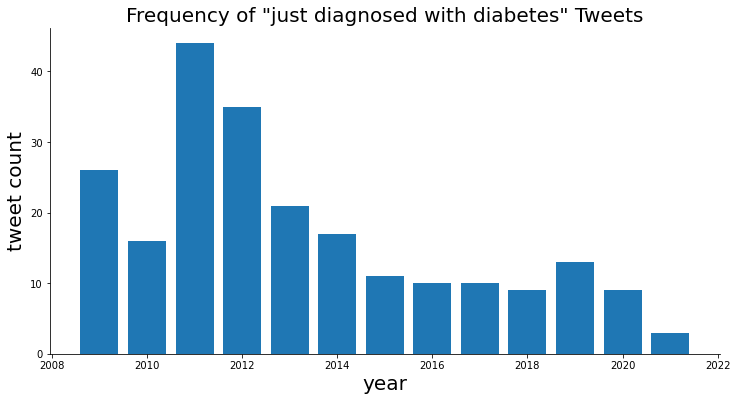

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(yearly_tweet_count.index, yearly_tweet_count['count'])
ax.set_ylabel('tweet count', fontsize=20)
ax.set_xlabel('year', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Frequency of "just diagnosed with diabetes" Tweets', fontsize=20)
plt.savefig('../plots/frequency_of_just_diagnosed_with_diabetes_tweets.pdf')

## Users

In [23]:
len(data)

224

In [24]:
N_users = len(data['author.id'].unique())
print('there are {} unique users in the dataset'.format(N_users))

there are 175 unique users in the dataset


### Diagnosis dates

In [27]:
diagnosis_dates = data[['author.id', 'author.username', 'created_at_date', 'created_at', 'id']]\
    .sort_values(by=['author.id', 'created_at_date'])\
    .reset_index(drop=True)\
    .drop_duplicates(subset=['author.id'])
diagnosis_dates.to_csv(join(src, 'twitter_user_diagnosis_dates.csv'), index=False)